In [20]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import statsmodels.stats.multitest as smm
from statsmodels.stats import weightstats
from matplotlib import pyplot as plt

In [3]:
data = pd.read_csv('ab_browser_test.csv')
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [6]:
clicks_exp = np.array(data[data['slot'] == 'exp']['n_clicks'])
clicks_control = np.array(data[data['slot'] == 'control']['n_clicks'])

In [13]:
(clicks_exp.sum() - clicks_control.sum())/clicks_control.sum()*100

1.6135689824415809

In [14]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [15]:
clicks_exp_bootstrap_mean = list(map(np.mean, get_bootstrap_samples(clicks_exp, 100)))
clicks_control_bootstrap_mean = list(map(np.mean, get_bootstrap_samples(clicks_control, 100)))

In [16]:
clicks_exp_bootstrap_median = list(map(np.median, get_bootstrap_samples(clicks_exp, 100)))
clicks_control_bootstrap_median = list(map(np.median, get_bootstrap_samples(clicks_control, 100)))

In [17]:
delta_mean = list(map(lambda x: x[1] - x[0], list(zip(clicks_exp_bootstrap_mean, clicks_control_bootstrap_mean))))
delta_median = list(map(lambda x: x[1] - x[0], list(zip(clicks_exp_bootstrap_median, clicks_control_bootstrap_median))))

In [18]:
stat_intervals(delta_mean, 0.05)

array([-0.394449  , -0.21549965])

In [19]:
stat_intervals(delta_median, 0.05)

array([-1., -1.])

In [27]:
np.random.seed(0)
n_boot_samples = 500
boot_samples = get_bootstrap_samples(clicks_control, n_boot_samples)
control_clicks_mean_scores   = list(map(np.mean, boot_samples))
control_boot_chi_squared = []
for i in range(n_boot_samples):
    control_boot_chi_squared.append(((boot_samples[i]-control_clicks_mean_scores[i])**2).sum())

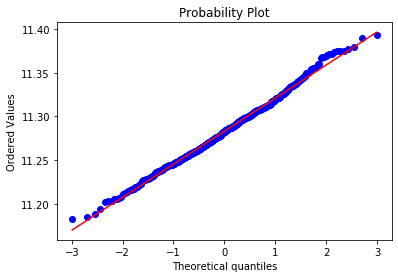

In [29]:
p1, p2 = stats.probplot(control_clicks_mean_scores, dist='norm', plot=plt)
plt.show()

In [31]:
p2[2]

0.9979748364604202

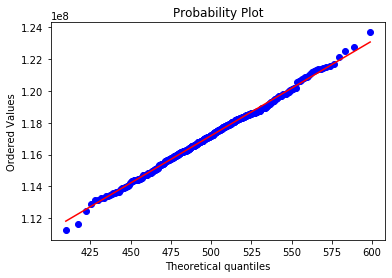

In [33]:
n = len(control_boot_chi_squared)
p1, p2 = stats.probplot(control_boot_chi_squared, dist='chi2',sparams=(n-1) ,plot=plt)
plt.show()

In [34]:
p2[2]

0.9986416698820314

In [37]:
clicks_exp = data[data['slot'] == 'exp'][['n_clicks', 'userID']]
clicks_control = data[data['slot'] == 'control'][['n_clicks', 'userID']]

In [41]:
clicks_exp = np.array(clicks_exp.groupby(by='userID').sum())
clicks_control = np.array(clicks_control.groupby(by='userID').sum())

In [42]:
stats.mannwhitneyu(clicks_exp, clicks_control)

MannwhitneyuResult(statistic=38901259929.0, pvalue=4.3471471887604393e-75)

In [51]:
p_values = []
for browser in set(data['browser'].values):
    clicks_exp = np.array(data[(data['slot'] == 'exp') & (data['browser'] == browser)]['n_clicks'])
    clicks_control = np.array(data[(data['slot'] == 'control') & (data['browser'] == browser)]['n_clicks'])
    print(browser)
    s = stats.mannwhitneyu(clicks_exp, clicks_control)
    print(s[1])
    p_values.append(s[1])

Browser #2
0.0272438604197241
Browser #22
0.2574055152210032
Browser #4
0.40760617658454984
Browser #14
0.0
Browser #17
0.03740060143010802
Browser #20
0.45366656388735377


In [52]:
multipletests(p_values, alpha=0.05, method='holm')

(array([False, False, False,  True, False, False]),
 array([0.1362193 , 0.77221655, 0.81521235, 0.        , 0.14960241,
        0.81521235]),
 0.008512444610847103,
 0.008333333333333333)